# Проект e-commerce: вариант 1 # 

#### Цель проекта

На основе данных проанализировать совершенные покупки и ответить на следующие вопросы:

 * Сколько у нас пользователей, которые совершили покупку только один раз?
 * Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
 * По каждому товару определить, в какой день недели товар чаще всего покупается.
 * Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
 * Используя pandas, провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.
 * Используя python, построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

### Обзор и предобработка данных

In [1]:
# импорт библиотек

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

In [2]:
sns.set(style='whitegrid', rc={'figure.figsize': (12, 6)})  # для картинок

In [3]:
# чтение файлов с данными и сохранение в olist_customers, olist_orders, olist_order_items

olist_customers = pd.read_csv('olist_customers_dataset.csv')
olist_orders = pd.read_csv('olist_orders_dataset.csv')
olist_items = pd.read_csv('olist_order_items_dataset.csv')

In [4]:
# обзор датафрейма olist_customers

olist_customers.info()
display(olist_customers)
print('Явных дубликатов:', olist_customers.duplicated().sum(), 'Доля дубликатов:',
      olist_customers.duplicated().sum() / len(olist_customers))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


Явных дубликатов: 0 Доля дубликатов: 0.0


 По описанию в задании датафрейм `olist_customers` является таблицей с уникальными идентификаторами пользователей и содержит 5 столбцов:
 
 * `customer_id` — позаказный идентификатор пользователя
 * `customer_unique_id` —  уникальный идентификатор пользователя (аналог номера паспорта)
 * `customer_zip_code_prefix` —  почтовый индекс пользователя
 * `customer_city` —  город доставки пользователя
 * `customer_state` —  штат доставки пользователя

In [5]:
# обзор датафрейма olist_orders

olist_orders.info()
display(olist_orders)
print('Явных дубликатов:', olist_orders.duplicated().sum(), 'Доля дубликатов:',
      olist_orders.duplicated().sum() / len(olist_orders))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


Явных дубликатов: 0 Доля дубликатов: 0.0


По описанию в задании датафрейм `olist_orders` является таблицей заказов и содержит 8 столбцов:

 * `order_id` —  уникальный идентификатор заказа (номер чека)
 * `customer_id` —  позаказный идентификатор пользователя
 * `order_status` —  статус заказа
 * `order_purchase_timestamp` —  время создания заказа
 * `order_approved_at` —  время подтверждения оплаты заказа
 * `order_delivered_carrier_date` —  время передачи заказа в логистическую службу
 * `order_delivered_customer_date` —  время доставки заказа
 * `order_estimated_delivery_date` —  обещанная дата доставки
 
 Уникальные статусы заказов в таблице `olist_orders`:
 
 * `created` —  создан
 * `approved` —  подтверждён
 * `invoiced` —  выставлен счёт
 * `processing` —  в процессе сборки заказа
 * `shipped` —  отгружен со склада
 * `delivered` —  доставлен пользователю
 * `unavailable` —  недоступен
 * `canceled` —  отменён

In [6]:
# обзор датафрейма olist_items

olist_items.info()
display(olist_items)
print('Явных дубликатов:', olist_items.duplicated().sum(), 'Доля дубликатов:',
      olist_items.duplicated().sum() / len(olist_items))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


Явных дубликатов: 0 Доля дубликатов: 0.0


По описанию в задании датафрейм `olist_items` является таблицей с товарными позициями, входящими в заказы, и содержит 7 столбцов:

* `order_id` —  уникальный идентификатор заказа (номер чека)
* `order_item_id` —  идентификатор товара внутри одного заказа
* `product_id` —  ид товара (аналог штрихкода)
* `seller_id` — ид производителя товара
* `shipping_limit_date` —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
* `price` —  цена за единицу товара
* `freight_value` —  вес товара 

Мы ознакомились с данными таблиц. Заметно, что тип данных в столбцах с датами не корректный (например,  время доставки заказа в таблице `olist_orders` имеет тип `object` или максимальная дата доставки продавцом для передачи заказа партнеру по логистике в таблице `olist_items` имеет так же тип `object`). 

In [7]:
# прочитаем еще раз файлы с данными, при этом сразу распарсим дату 
# снова сохраним данные в olist_customers, olist_orders, olist_items

olist_customers   = pd.read_csv('olist_customers_dataset.csv')
olist_orders      = pd.read_csv('olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 
                                                                         'order_approved_at', 
                                                                         'order_delivered_carrier_date', 
                                                                         'order_delivered_customer_date', 
                                                                         'order_estimated_delivery_date'])
olist_items = pd.read_csv('olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])

In [8]:
olist_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [9]:
olist_items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

В наших данных нет явных дубликатов, но мы видим, что в данных таблицы заказов по столбцам `order_approved_at`, `order_delivered_carrier_date`, `order_delivered_customer_date` имеются пропуски. Можно сделать вывод, что не все заказы  были доставлены до пункта назначения.

Посмотрим, за какой период мы располагаем данными в таблице заказов. 

In [10]:
olist_orders.min()

order_id                         00010242fe8c5a6d1ba2dd792cb16214
customer_id                      00012a2ce6f8dcda20d059ce98491703
order_status                                             approved
order_purchase_timestamp                      2016-09-04 21:15:19
order_approved_at                             2016-09-15 12:16:38
order_delivered_carrier_date                  2016-10-08 10:34:01
order_delivered_customer_date                 2016-10-11 13:46:32
order_estimated_delivery_date                 2016-09-30 00:00:00
dtype: object

In [11]:
olist_orders.max()

order_id                         fffe41c64501cc87c801fd61db3f6244
customer_id                      ffffe8b65bbe3087b653a978c870db99
order_status                                          unavailable
order_purchase_timestamp                      2018-10-17 17:30:18
order_approved_at                             2018-09-03 17:40:06
order_delivered_carrier_date                  2018-09-11 19:48:28
order_delivered_customer_date                 2018-10-17 13:22:46
order_estimated_delivery_date                 2018-11-12 00:00:00
dtype: object

### 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Чтобы ответить на вопрос задания, нужно понять, что должно считаться покупкой. Покупку будем считать совершенной в том случае, если оплата заказа была подтверждена, при этом заказы не были отменены и недоступны. Следовательно, нас интересуют заказы с указанным временем подтверждения оплаты (`order_approved_at` без пропусков) без учета отмененных (`canceled`) и недоступных (`unavailable`) заказов.

In [12]:
# посмотрим на распределение заказов по статусам

olist_orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

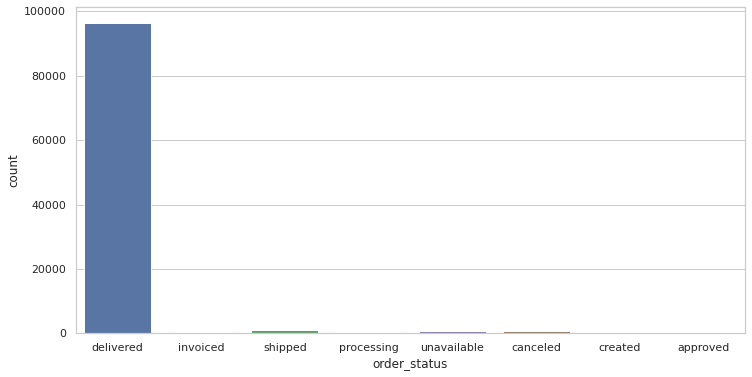

In [13]:
# визуализация распределения заказов по статусам

sns.countplot(data=olist_orders, x='order_status')

In [14]:
# создадим колонку с подтверждением платежа True или False

olist_orders['proof_of_payment'] = olist_orders.order_approved_at.notna()

In [15]:
# отфильтуем датафрейм olist_orders, чтобы получить данные с совершенными покупками 

purchases = (olist_orders.loc[(olist_orders.order_status != 'canceled') &
                             (olist_orders.order_status != 'unavailable') &
                             (olist_orders.proof_of_payment == True)])

In [16]:
# объединим данные по пользователям olist_customers c полученными данными с покупками purchases

purch_and_cust = olist_customers.merge(purchases, on='customer_id', how='inner')

In [17]:
# количество уникальных пользователей, совершивших одну покупку

just_one_purchase = (purch_and_cust.groupby('customer_unique_id', as_index=False)
                                   .agg({'order_approved_at': 'count'})
                                   .query('order_approved_at == 1') 
                                   .customer_unique_id.nunique())

In [18]:
# в процентном отношении

per_one_purchase = round(just_one_purchase / len(purch_and_cust['customer_unique_id'].unique()) * 100)

In [19]:
# пользователь, совершивший наибольшее количество покупок 

purch_and_cust.groupby('customer_unique_id', as_index=False) \
              .agg({'order_approved_at': 'count'}) \
              .max()

customer_unique_id    ffffd2657e2aad2907e67c3e9daecbeb
order_approved_at                                   16
dtype: object

##### Ответ 

In [20]:
print('Всего:', just_one_purchase, 'пользователей совершили покупку только один раз, это составляет:', 
      per_one_purchase, '% от всех пользователей')

Всего: 92087 пользователей совершили покупку только один раз, это составляет: 97 % от всех пользователей


### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Причины, по которым заказ не доставляется, можно увидеть в статусах заказов `order_status`, их всего две:

* заказ отменен `canceled` 
* заказ недоступен `unavailable`

Рассмотрим их детальнее, посчитаем среднее количество не доставленных заказов в месяц по каждой из этих причин.

In [21]:
olist_orders.set_index(keys='order_purchase_timestamp', drop=True, inplace=True)

In [22]:
olist_orders.head()

,order_id,customer_id,order_status,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,proof_of_payment
order_purchase_timestamp,,,,,,,,
2017-10-02 10:56:33,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,True
2018-07-24 20:41:37,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,True
2018-08-08 08:38:49,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,True
2017-11-18 19:28:06,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,True
2018-02-13 21:18:39,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,True


In [23]:
# отмененные заказы по месяцам

orders_canceled = (olist_orders.query('order_status == "canceled"')
                               .resample(rule='M')
                               .order_id.count()
                               .reset_index())
orders_canceled

,order_purchase_timestamp,order_id
0,2016-09-30,2
1,2016-10-31,24
2,2016-11-30,0
3,2016-12-31,0
4,2017-01-31,3
5,2017-02-28,17
6,2017-03-31,33
7,2017-04-30,18
8,2017-05-31,29
9,2017-06-30,16


In [24]:
# недоступные заказы по месяцам

orders_unavailable = (olist_orders.query('order_status == "unavailable"')
                                  .resample(rule='M')
                                  .order_id.count()
                                  .reset_index())
orders_unavailable

,order_purchase_timestamp,order_id
0,2016-10-31,7
1,2016-11-30,0
2,2016-12-31,0
3,2017-01-31,10
4,2017-02-28,45
5,2017-03-31,32
6,2017-04-30,9
7,2017-05-31,31
8,2017-06-30,24
9,2017-07-31,52


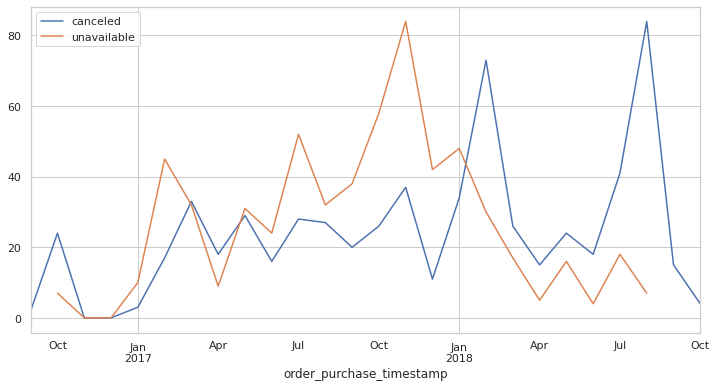

In [25]:
# еще можно посмотреть на графике

olist_orders[olist_orders.order_status == 'canceled'].resample(rule='M').size().plot(label='canceled')
olist_orders[olist_orders.order_status == 'unavailable'].resample(rule='M').size().plot(label='unavailable')
plt.legend()
plt.show()

In [26]:
# среднее кол-во отмененных заказов в месяц

orders_canceled_mean = orders_canceled.order_id.mean().round(0)

In [27]:
# среднее кол-во недоступных заказов в месяц

orders_unavailable_mean = orders_unavailable.order_id.mean().round(0)

##### Ответ 

In [28]:
print(orders_canceled_mean, '- среднее количество отмененных заказов в месяц') 
print(orders_unavailable_mean, '- среднее количество недоступных заказов в месяц'),
print('Всего в среднем', orders_canceled_mean + orders_unavailable_mean, 'заказов не доставляется в месяц')

24.0 - среднее количество отмененных заказов в месяц
26.0 - среднее количество недоступных заказов в месяц
Всего в среднем 50.0 заказов не доставляется в месяц


### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [29]:
# объединим данные по совершенным покупкам purchases c данными по товарам olist_items

purchases_items = purchases.merge(olist_items)
purchases_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,proof_of_payment,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,True,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,True,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,True,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,True,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,True,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [30]:
# создадим новую колонку с днями недели

purchases_items['weekday'] = purchases_items.order_approved_at.dt.day_name()

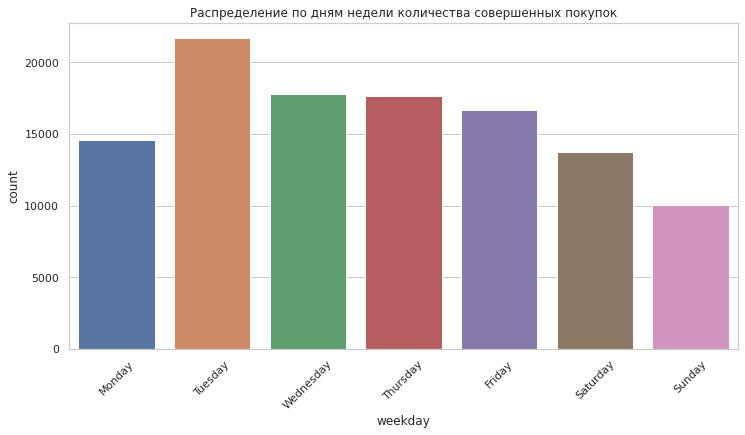

In [31]:
# посмотрим на графике распределение покупок по дням недели

order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.countplot(data=purchases_items, x='weekday', order=order)
ax.tick_params(axis='x', rotation=45)
ax.set_title('Распределение по дням недели количества совершенных покупок')

plt.show()

Рассмотрев построенный выше график, можем сделать вывод, что чаще всего покупок происходит во вторник, а реже всего - в воскресение. Определим, в какой день недели чаще всего покупается каждый из товаров. Для этого посчитаем моду (значение, которое встречается наиболее часто).

In [34]:
# считаем моду по каждому товару

products_by_weekday = purchases_items.groupby('product_id', as_index=False).agg({'weekday': pd.Series.mode})

##### Ответ

In [35]:
products_by_weekday.head()

,product_id,weekday
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Friday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [36]:
# добавим колонку month к данным по пользователям и совершеным покупкам purch_and_cust

purch_and_cust['month'] = pd.to_datetime(purch_and_cust.order_approved_at.dt.strftime('%Y-%m'))

Так как в наших данных имеются неполные данные по продажам за сентябрь 2016 и сентябрь 2018, то данные за этот период можно отсечь.

In [37]:
purch_and_cust = purch_and_cust.loc[(purch_and_cust.month > '2016-09') & (purch_and_cust.month < '2018-09')]

In [38]:
# количество покупок по пользователям и месяцам

purch_and_cust_per_week = (purch_and_cust.groupby(['customer_unique_id', 'month'], as_index=False)
                                      .order_id.count()
                                      .rename(columns={'order_id': 'purchases'}))

In [39]:
# добавим колонку weeks с количеством недель в месяце

purch_and_cust_per_week['weeks'] = round(purch_and_cust_per_week.month.dt.daysinmonth / 7, 2)

In [40]:
# добавим колонку purchases_per_week с количеством покупок в неделю

purch_and_cust_per_week['purchases_per_week'] = round(purch_and_cust_per_week.purchases / purch_and_cust_per_week.weeks, 2)

##### Ответ

In [41]:
purch_and_cust_per_week.sort_values(['customer_unique_id', 'month']).head()

,customer_unique_id,month,purchases,weeks,purchases_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,1,4.43,0.23
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,1,4.43,0.23
2,0000f46a3911fa3c0805444483337064,2017-03-01,1,4.43,0.23
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,1,4.43,0.23
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,1,4.29,0.23


### 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

Когорты мы будем строить на дату создания заказа (order_purchase_timestamp), будем считать эту дату первым приходом пользователя. 

In [42]:
# возьмем датафрейм из прошлого задания и выберем нужные столбцы

purch_and_cust_unique = purch_and_cust_per_week[['customer_unique_id', 'month']]

In [43]:
purch_and_cust_unique['month'] = purch_and_cust_unique.month.dt.to_period('M')

In [44]:
# для каждого клиента посчитаем год/месяц первого заказа

purch_and_cust_from = (purch_and_cust.groupby('customer_unique_id', as_index=False)
                                     .agg({'order_purchase_timestamp': 'min'}))

Поскольку мы проводим ежемесячные когорты, мы будем смотреть на общее ежемесячное поведение наших пользователей. Поэтому нам не нужны детализированные данные order_purchase_timestamp.

In [45]:
purch_and_cust_from['cohort_month'] = purch_and_cust_from.order_purchase_timestamp.dt.to_period('M')

In [46]:
# смёрджим оба датафрейма по номеру клиента

cohorts_merge = purch_and_cust_unique.merge(purch_and_cust_from, on='customer_unique_id')

In [47]:
# посчитаем уникальных пользователей в когортах по месяцам покупок

cohorts = (cohorts_merge.groupby(['cohort_month', 'month'], as_index=False)
                        .agg({'customer_unique_id': pd.Series.nunique})
                        .rename(columns={'customer_unique_id': 'num_customer'}))

In [48]:
# посчитаем, сколько прошло месяцев между первым заказом и датой покупки заказа

cohorts['cohort_period'] = (cohorts.month - cohorts.cohort_month).apply(attrgetter('n'))

In [49]:
cohorts.head()

,cohort_month,month,num_customer,cohort_period
0,2016-09,2016-10,1,1
1,2016-10,2016-10,290,0
2,2016-10,2017-04,1,6
3,2016-10,2017-07,1,9
4,2016-10,2017-09,1,11


Так как по 2016 и 2018 годам у нас мало данных, то уберем когорты 2016-го и 2018-го гг и дополнительно включим для когорты 2017-12 продажи за 2018 год.

In [51]:
cohorts = cohorts.query('"2016-12" < cohort_month < "2018-01" and month < "2018-04"')

Мы хотим посмотреть на процентное изменение каждой когорты с течением времени, а не на абсолютное изменение.
Для этого нам сначала нужно создать серию pandas, содержащую каждую когорту и ее размер.

In [52]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort_period', 'cohort_month'], inplace=True)
cohort_group_size = cohorts['num_customer'].groupby(level=1).first()
cohort_group_size.head()

cohort_month
2017-01     716
2017-02    1640
2017-03    2543
2017-04    2272
2017-05    3490
Freq: M, Name: num_customer, dtype: int64

Теперь нам нужно разделить `num_customer` значения в `cohorts` на `cohort_group_size`. Поскольку операции DataFrame выполняются на основе индексов объектов, мы будем использовать `unstack` DataFrame для наших когорт для создания матрицы, где каждый столбец представляет `cohort_month`, а каждая строка — `cohort_period`, соответствующий этой группе.

In [54]:
cohorts['num_customer'].head()

cohort_period  cohort_month
0              2017-01         716
1              2017-01          38
2              2017-01           2
3              2017-01           1
4              2017-01           3
Name: num_customer, dtype: int64

In [55]:
cohorts['num_customer'].unstack(1).head()

cohort_month,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohort_period,,,,,,,,,,,,
0,716.0,1640.0,2543.0,2272.0,3490.0,3059.0,3733.0,4065.0,4032.0,4317.0,6977.0,5380.0
1,38.0,41.0,41.0,67.0,69.0,57.0,109.0,92.0,69.0,105.0,250.0,69.0
2,2.0,5.0,9.0,5.0,17.0,11.0,13.0,15.0,21.0,13.0,28.0,15.0
3,1.0,3.0,10.0,4.0,13.0,12.0,8.0,11.0,14.0,4.0,12.0,19.0
4,3.0,7.0,9.0,7.0,11.0,8.0,12.0,15.0,17.0,10.0,14.0,NaN


Теперь мы можем разделить каждый столбец на соответствующий cohort_group_size.
Результирующий DataFrame `retention` содержит процент пользователей из когорты, совершающих покупки в течение заданного периода. 

In [56]:
retention = cohorts['num_customer'].unstack(0).divide(cohort_group_size, axis=0)
retention.head(10)

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cohort_month,,,,,,,,,,,,,,,
2017-01,1.0,0.053073,0.002793,0.001397,0.004190,0.001397,0.004190,0.001397,0.001397,NaN,0.002793,0.002793,0.006983,0.004190,0.001397
2017-02,1.0,0.025000,0.003049,0.001829,0.004268,0.001220,0.002439,0.001829,0.000610,0.001829,0.001220,0.003049,0.001220,0.001829,NaN
2017-03,1.0,0.016123,0.003539,0.003932,0.003539,0.001573,0.001573,0.003146,0.003146,0.001180,0.003932,0.001180,0.002359,NaN,NaN
2017-04,1.0,0.029489,0.002201,0.001761,0.003081,0.002641,0.003521,0.002641,0.003521,0.001761,0.002641,0.000880,NaN,NaN,NaN
2017-05,1.0,0.019771,0.004871,0.003725,0.003152,0.003438,0.004298,0.001433,0.002579,0.002292,0.002865,NaN,NaN,NaN,NaN
2017-06,1.0,0.018634,0.003596,0.003923,0.002615,0.003923,0.003596,0.002288,0.001308,0.002288,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.029199,0.003482,0.002143,0.003215,0.002143,0.003215,0.001072,0.001875,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.022632,0.003690,0.002706,0.003690,0.005412,0.002952,0.002706,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.017113,0.005208,0.003472,0.004216,0.002480,0.002232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# Довольно сложно воспринимать подобную информацию без цвета, поэтому применяем:

retention_style = (retention.style
                            .set_caption('Retention by cohort')  # добавляем подпись
                            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
                            .highlight_null('white')  # делаем белый фон для значений NaN
                            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
retention_style

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cohort_month,,,,,,,,,,,,,,,
2017-01,100.00%,5.31%,0.28%,0.14%,0.42%,0.14%,0.42%,0.14%,0.14%,,0.28%,0.28%,0.70%,0.42%,0.14%
2017-02,100.00%,2.50%,0.30%,0.18%,0.43%,0.12%,0.24%,0.18%,0.06%,0.18%,0.12%,0.30%,0.12%,0.18%,
2017-03,100.00%,1.61%,0.35%,0.39%,0.35%,0.16%,0.16%,0.31%,0.31%,0.12%,0.39%,0.12%,0.24%,,
2017-04,100.00%,2.95%,0.22%,0.18%,0.31%,0.26%,0.35%,0.26%,0.35%,0.18%,0.26%,0.09%,,,
2017-05,100.00%,1.98%,0.49%,0.37%,0.32%,0.34%,0.43%,0.14%,0.26%,0.23%,0.29%,,,,
2017-06,100.00%,1.86%,0.36%,0.39%,0.26%,0.39%,0.36%,0.23%,0.13%,0.23%,,,,,
2017-07,100.00%,2.92%,0.35%,0.21%,0.32%,0.21%,0.32%,0.11%,0.19%,,,,,,
2017-08,100.00%,2.26%,0.37%,0.27%,0.37%,0.54%,0.30%,0.27%,,,,,,,
2017-09,100.00%,1.71%,0.52%,0.35%,0.42%,0.25%,0.22%,,,,,,,,


##### Ответ

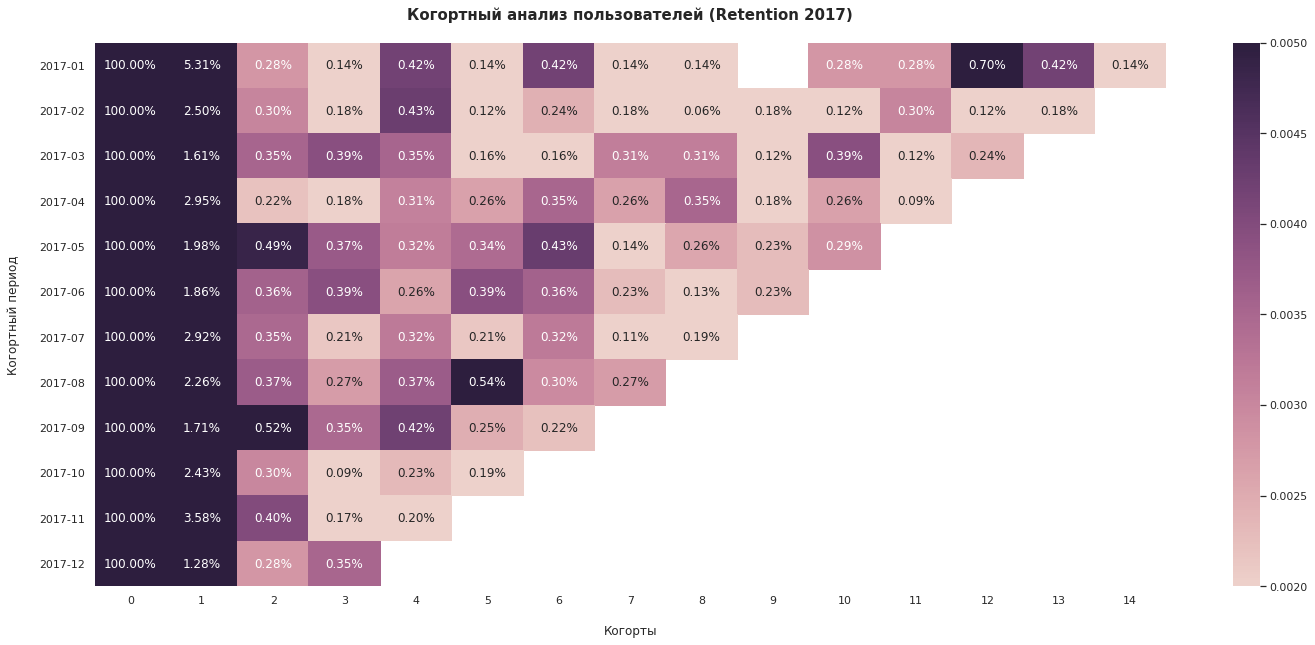

In [59]:
# построим heatmap

plt.figure(figsize=(24, 10))
plt.title('Cohorts: Retention')
sns.heatmap(retention, vmin=0.002, vmax=0.005, cmap=sns.cubehelix_palette(as_cmap=True), annot=True, fmt='.2%')
plt.title('Когортный анализ пользователей (Retention 2017)\n', fontsize=15, fontweight = 'bold')
plt.xlabel('\nКогорты')
plt.ylabel('Когортный период\n')
plt.show()

В период с января по декабрь когортами с самым высоким retention на 3-й месяц являются `2017-03` и `2017-06` по 0,39%.

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

 Для того, что провести RFM-анализ, нужно определить параметры Recency (R), Frequency (F) и Monetary (M).

* Recency (Давность). Сколько времени (часов, дней, недель, месяцев) прошло с момента последней покупки клиента. Недавность будем опеделять от даты покупки `order_approved_at` до текущей даты today.

* Frequency (Частота). Как часто пользователь совершает покупки или другие целевые действия. Показывает, сколько взаимодействий (покупок) в течение определённого периода времени было с клиентом. Количество покупок будем определять по количеству уникальных заказов `order_id` за период анализа. Frequency как количество уникальных заказов, оплаченных полльзователем за весь период анализа.

* Monetary (Вложения). Сколько средств потратил пользователь за определенный промежуток времени. Monetary будем определять по прайсовой стоимости товаров `price`, входящих в заказы.

In [58]:
# находим monetary по прайсовой стоимости заказов

purchases_cost = (purchases_items.groupby('order_id', as_index=False)
                                 .agg({'price': 'sum'})
                                 .rename(columns={'price': 'monetary'}))

In [68]:
purchases_cost.head()

,order_id,monetary
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90


In [66]:
# объединим полученный датафрейм с таблицей с совершенными покупками

purch_cost_merge = purch_and_cust.merge(purchases_cost, on='order_id', how='left')
purch_cost_merge.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,proof_of_payment,month,monetary
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,True,2017-05-01,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,True,2018-01-01,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,True,2018-05-01,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,True,2018-03-01,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,True,2018-07-01,230.00


In [67]:
# находим последнюю текущую дату

today = max(purch_cost_merge.order_purchase_timestamp.max(), purch_cost_merge.order_approved_at.max())

In [73]:
# находим frequency, покупки пользователей

purch_by_cust = (purch_cost_merge.groupby('customer_unique_id', as_index=False)
                                 .agg({'order_approved_at': 'max', 'order_id': 'nunique', 'monetary': 'sum'})
                                 .rename(columns={'order_id': 'frequency', 'order_approved_at': 'order_approved_at_max'})
                                 .sort_values('monetary', ascending=False))
purch_by_cust.head()

,customer_unique_id,order_approved_at_max,frequency,monetary
3788,0a0a92112bd4c708ca5fde585afaa872,2017-10-02 15:28:20,1,13440.0
81001,da122df9eeddfedc1dc1f5349a1a690c,2017-04-03 13:25:19,2,7388.0
43937,763c8b1c9c68a0229c42c9fc6f662b93,2018-07-17 04:31:36,1,7160.0
81840,dc4802a71eae9be1dd28f5d788ceb526,2017-02-12 20:45:12,1,6735.0
25901,459bef486812aa25204be022145caa62,2018-07-27 04:05:13,1,6729.0


In [76]:
# находим recency до текущей даты

purch_by_cust['recency'] = (today - purch_by_cust.order_approved_at_max).dt.days

In [78]:
# удалим столбец order_approved_at_max

purch_by_cust = purch_by_cust.drop(columns='order_approved_at_max')

In [80]:
# оставим в данных только тех пользователей, у которых есть показатели purchases, monetary и recency

rfm = purch_by_cust.dropna(subset=['frequency', 'recency']).query('monetary > 0')

In [82]:
rfm.head()

,customer_unique_id,frequency,monetary,recency
3788,0a0a92112bd4c708ca5fde585afaa872,1,13440.0,330
81001,da122df9eeddfedc1dc1f5349a1a690c,2,7388.0,513
43937,763c8b1c9c68a0229c42c9fc6f662b93,1,7160.0,43
81840,dc4802a71eae9be1dd28f5d788ceb526,1,6735.0,562
25901,459bef486812aa25204be022145caa62,1,6729.0,33


Посмотрим, как лучше разбить на сегменты наши метрики

In [83]:
rfm.recency.describe()

count    94969.000000
mean       237.328360
std        152.952531
min          0.000000
25%        113.000000
50%        218.000000
75%        346.000000
max        694.000000
Name: recency, dtype: float64

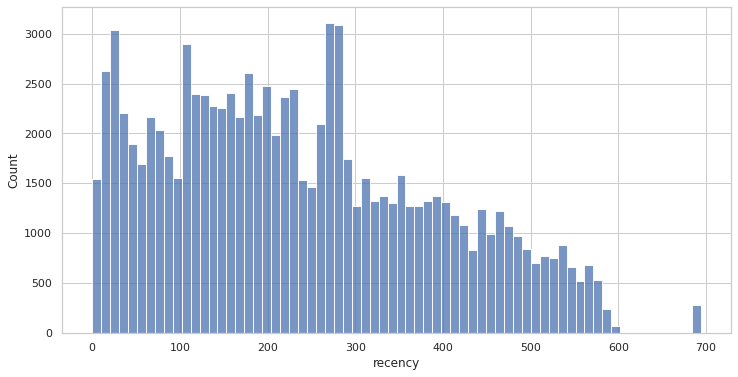

In [84]:
sns.histplot(rfm, x='recency')

In [85]:
rfm.recency.quantile(q=[0.3, 0.7])

0.3    134.0
0.7    312.0
Name: recency, dtype: float64

Можно разбить recency на следующие сегменты: 
    
* 1 - `больше 350` дней 
* 2 - `220-350` дней 
* 3 - `115-220` дней 
* 4 - `меньше 115` дней 

In [86]:
rfm.frequency.describe()

count    94969.000000
mean         1.033843
std          0.210779
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: frequency, dtype: float64

In [87]:
rfm.frequency.value_counts()

1     92084
2      2649
3       188
4        29
5         9
6         5
7         3
16        1
9         1
Name: frequency, dtype: int64

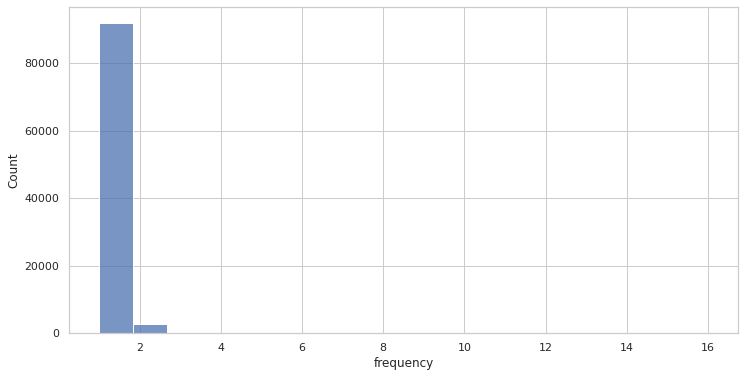

In [88]:
sns.histplot(rfm, x='frequency')

Большая часть пользователей совершили одну покупку. Метрику можно разбить на следующие сегменты:

* 1 - `1` покупка 
* 2 - `2` покупки 
* 3 - `3-4` покупки 
* 4 - `больше 4` покупок 

In [89]:
rfm.monetary.describe()

count    94969.000000
mean       142.072153
std        216.086436
min          0.850000
25%         47.900000
50%         89.890000
75%        155.000000
max      13440.000000
Name: monetary, dtype: float64

Основная часть значений (порядка 90%) Monetary лежит в пределах примерно до 300-400, делить будем от этой цифры

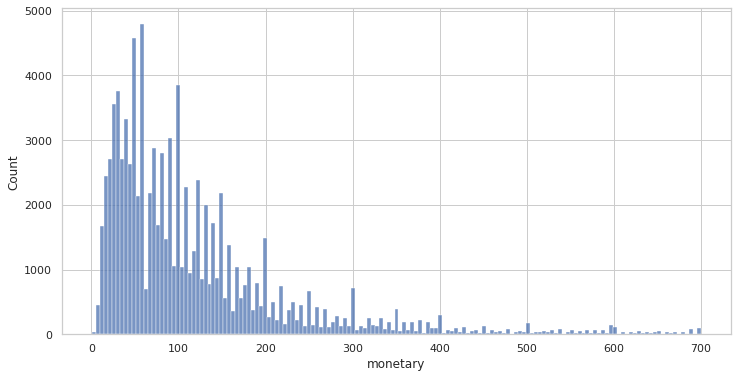

In [90]:
sns.histplot(rfm[rfm.monetary < 700], x='monetary')

Мonetary разбиваем на следующие сегменты:

* 1 - `до 90` 
* 2 - `от 90 до 155` 
* 3 - `от 155 до 300`
* 4 - `больше 300`

In [91]:
def r_score(x):
    if x <= 115:
        return 4
    elif x <= 220:
        return 3
    elif x <= 350:
        return 2
    else:
        return 1
    
    
def f_score(x):
    if x > 4:
        return 4
    elif x > 2:
        return 3
    elif x > 1:
        return 2
    else:
        return 1  
    
    
def m_score(x):
    if x >= 300:
        return 4
    elif x >= 155:
        return 3
    elif x >= 90:
        return 2
    else:
        return 1 

In [92]:
# получим оценки R, F и M каждого пользователя

rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['monetary'].apply(lambda x: m_score(x))

In [93]:
# объединим оценки R, F и M в файл RFM Score

rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,customer_unique_id,frequency,monetary,recency,R,F,M,RFM Score
3788,0a0a92112bd4c708ca5fde585afaa872,1,13440.0,330,2,1,4,214
81001,da122df9eeddfedc1dc1f5349a1a690c,2,7388.0,513,1,2,4,124
43937,763c8b1c9c68a0229c42c9fc6f662b93,1,7160.0,43,4,1,4,414
81840,dc4802a71eae9be1dd28f5d788ceb526,1,6735.0,562,1,1,4,114
25901,459bef486812aa25204be022145caa62,1,6729.0,33,4,1,4,414


In [101]:
# описание сегментов

description = pd.DataFrame({'Segment': ['new_a_lot', 'fav', 'potential', 
                                         'long_ago', 'keep', 'return', 'non active', 'new'],
                        'Description': ['Покупали недавно и много',
                                        'Покупают много, но не так часто',
                                        'Покупали недавно и могут покупать чаще',
                                        'Требуют внимания, совершили 1 покупку',
                                        'Нужно удержать',
                                        'Нужно вернуть',
                                        'Неактивные',
                                        'Новые']})
description

,Segment,Description
0,new_a_lot,Покупали недавно и много
1,fav,"Покупают много, но не так часто"
2,potential,Покупали недавно и могут покупать чаще
3,long_ago,"Требуют внимания, совершили 1 покупку"
4,keep,Нужно удержать
5,return,Нужно вернуть
6,non active,Неактивные
7,new,Новые


In [102]:
segt_map = {
    r'[1-2][1-2]': 'non active',
    r'1[3-4]': 'return',  
    r'2[3-4]': 'keep',
    r'3[3-4]': 'fav',
    r'31': 'long_ago',
    r'41': 'new',
    r'[3-4]2': 'potential',
    r'4[3-4]': 'new_a_lot'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head()

,customer_unique_id,frequency,monetary,recency,R,F,M,RFM Score,Segment
3788,0a0a92112bd4c708ca5fde585afaa872,1,13440.0,330,2,1,4,214,non active
81001,da122df9eeddfedc1dc1f5349a1a690c,2,7388.0,513,1,2,4,124,non active
43937,763c8b1c9c68a0229c42c9fc6f662b93,1,7160.0,43,4,1,4,414,new
81840,dc4802a71eae9be1dd28f5d788ceb526,1,6735.0,562,1,1,4,114,non active
25901,459bef486812aa25204be022145caa62,1,6729.0,33,4,1,4,414,new


Визуализируем сегменты наших клиентов. Теперь, когда у нас есть оценки, мы можем визуализировать данные, чтобы лучше понять портфолио наших клиентов. Во-первых, давайте посмотрим на распределение R, F и M.

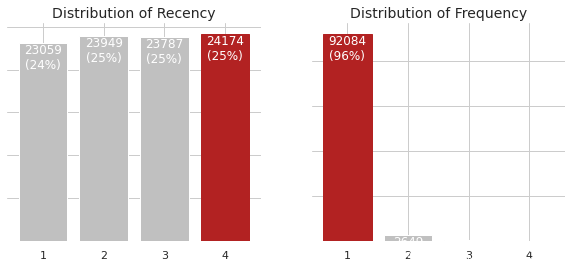

In [103]:
# plot the distribution of customers over R and F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R': 'Recency', 'F': 'Frequency'}
    y = rfm[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Distribution of {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
                ha='center',
                va='top',
                color='w')

plt.show()

Мы видим, что давность `recency` кажется равномерно распределенной, в то время как по `frequency` видно, что больше всего клиентов совершили один заказ.

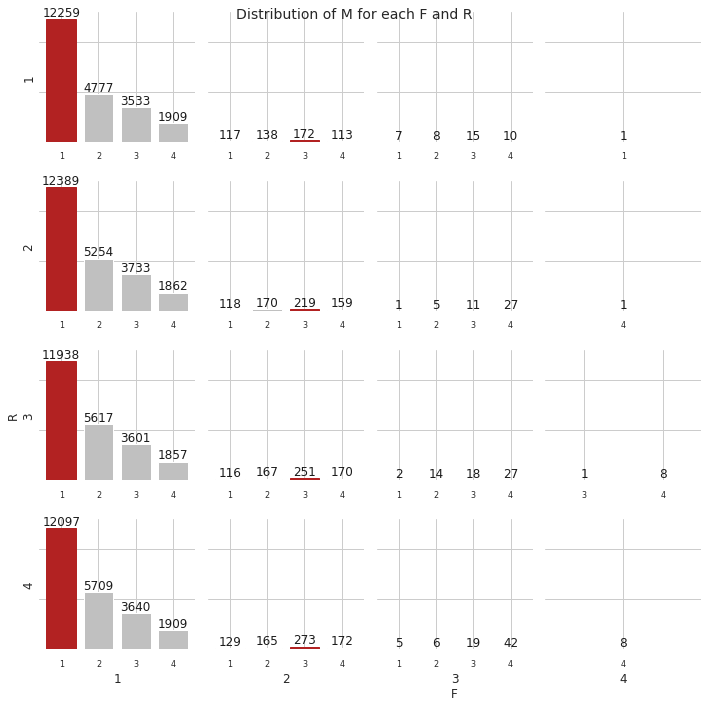

In [104]:
# plot the distribution of M for RF score
fig, axes = plt.subplots(nrows=4, ncols=4,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 5)
f_range = range(1, 5)
for r in r_range:
    for f in f_range:
        y = rfm[(rfm['R'] == r) & (rfm['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 4:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution of M for each F and R',
             fontsize=14)
plt.tight_layout()
plt.show()

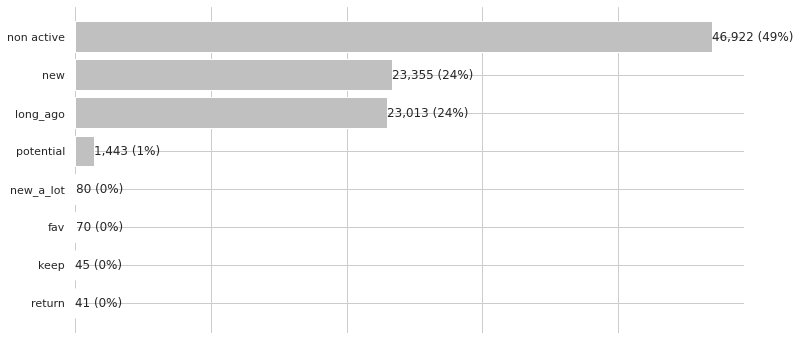

In [105]:
# count the number of customers in each segment
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height() / 2,
                '{:,} ({:}%)'.format(int(value),
                int(value * 100 / segments_counts.sum())),
                va='center',
                ha='left')

plt.show()

Большинство пользователей являются неактивными (~ 49%), но так же довольно значительное количество (~ 24%) попало в группы новых пользователей, которые требуют внимания. Лояльных пользователей совсем немного (купили недавно и много - 80, много, но давно - 70). Имея клиентов, распределенных по сегментам, и некоторые статистические данные о составе нашего клиентского портфеля, мы можем работать над целевыми маркетинговыми кампаниями, чтобы удержать клиентов, находящихся в группе риска, улучшить продажи клиентам с некоторым потенциалом и вознаградить лучших клиентов.

##### Ответ

In [106]:
# классифицируем пользователей на RFM кластеры
    
rfm.head()

,customer_unique_id,frequency,monetary,recency,R,F,M,RFM Score,Segment
3788,0a0a92112bd4c708ca5fde585afaa872,1,13440.0,330,2,1,4,214,non active
81001,da122df9eeddfedc1dc1f5349a1a690c,2,7388.0,513,1,2,4,124,non active
43937,763c8b1c9c68a0229c42c9fc6f662b93,1,7160.0,43,4,1,4,414,new
81840,dc4802a71eae9be1dd28f5d788ceb526,1,6735.0,562,1,1,4,114,non active
25901,459bef486812aa25204be022145caa62,1,6729.0,33,4,1,4,414,new


In [108]:
# средние метрики по каждому кластеру пользователей

rfm_clusters = (rfm.groupby('Segment', as_index=False)
                   .agg({'recency': 'mean', 'frequency': 'mean', 'monetary': 'mean', 'customer_unique_id': 'nunique'})
                   .rename(columns={'recency': 'R_mean', 'frequency': 'F_mean', 'monetary': 'M_mean'}))
rfm_clusters.head()

,Segment,R_mean,F_mean,M_mean,customer_unique_id
0,fav,160.400000,3.457143,363.140571,70
1,keep,286.866667,3.155556,512.816667,45
2,long_ago,167.286099,1.000000,136.200450,23013
3,new,57.361593,1.000000,140.413729,23355
4,new_a_lot,55.212500,3.600000,514.834750,80
